In [5]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [71]:
"""
code du lightgbm repris (et adapté) de :
Lien : https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's 
categorical features. Other tables are using one-hot encode with mean, 
sum and a few different functions to aggregate. The main ideia was to add 
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import gc
import time
import numpy as np
import pandas as pd
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb
from lightgbm import LGBMClassifier
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, classification_report
import warnings

from pprint import pprint
import mlflow 
import mlflow.sklearn
from mlflow import MlflowClient

warnings.simplefilter(action="ignore", category=FutureWarning)

In [51]:
from src.p7_constantes import (
    MODEL_DIR,
    DATA_BASE,
    DATA_INTERIM,
    LOCAL_URI,
    LOCAL_HOST,
    LOCAL_PORT,
)

%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("Scikit-learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

Numpy: 1.26.4
Pandas: 2.2.2
Scikit-learn: 1.4.2
MLFlow: 2.12.1


In [ ]:
"""
"feature": "ORGANIZATION_TYPE", "table": "application", "description": "Type of organization where client works", "agg": None

CREDIT_TO_ANNUITY_RATIO:
bureau["CREDIT_TO_ANNUITY_RATIO"] = bureau["AMT_CREDIT_SUM"] / bureau["AMT_ANNUITY"]
prev["CREDIT_TO_ANNUITY_RATIO"] = prev["AMT_CREDIT"] / prev["AMT_ANNUITY"]
(df=Application) df["CREDIT_TO_ANNUITY_RATIO"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]

"feature": "AMT_CREDIT", "table": "application", "description": "Credit amount of the loan", "agg": None
"feature": "AMT_ANNUITY", "table": "application", "description": "Loan annuity", "agg": None

EXT_SOURCES_MEAN
for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXT_SOURCES_{}".format(function_name.upper())
        df[feature_name] = eval("np.{}".format(function_name))(
            df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1
        )

On va éviter une multicolinéarité trop forte en ne prenant pas toutes les features ext_sources. On va garder la EXT_SOURCES_MEAN et la EXT_SOURCE_3
"feature": "EXT_SOURCE_1", "table": "application", "description": "Normalized score from external data source", "agg": "None"
"feature": "EXT_SOURCE_2", "table": "application", "description": "Normalized score from external data source", "agg": "None"
"feature": "EXT_SOURCE_3", "table": "application", "description": "Normalized score from external data source", "agg": "None"

"feature": "DAYS_BIRTH", "table": "application", "description": "Client's age in days at the time of application", "agg": "None"

"feature": "DAYS_CREDIT_ENDDATE", "table": "bureau", "description": "Remaining duration of CB credit (in days) at the time of application in Home Credit", "agg": "max"

# On ne garde pas AMT_ANNUITY ?? Faire une matrice de corrélation ?
"feature": "AMT_ANNUITY", "table": "application", "description": "Loan annuity", "agg": "None"

CREDIT_TO_GOODS_RATIO
df["CREDIT_TO_GOODS_RATIO"] = df["AMT_CREDIT"] / df["AMT_GOODS_PRICE"]
"feature": "AMT_CREDIT", "table": "application", "description": "Credit amount of the loan", "agg": "None"
"feature": "AMT_GOODS_PRICE", "table": "application", "description": "For consumer loans it is the price of the goods for which the loan is given", "agg": "None"


"feature": "OCCUPATION_TYPE", "table": "application", "description": "What kind of occupation does the client have", "agg": "None"

"feature": "DAYS_ID_PUBLISH", "table": "application", "description": "How many days before the application did client change the identity document with which he applied for the loan", "agg": "None"

"feature": "DAYS_EMPLOYED", "table": "application", "description": "How many days before the application the person started current employment", "agg": "None"

BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN
bureau["DEBT_CREDIT_DIFF"] = (
        bureau["AMT_CREDIT_SUM"] - bureau["AMT_CREDIT_SUM_DEBT"]
    )
    
# General loans aggregations
    agg_bureau = group(bureau, "BUREAU_", BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
    agg_bureau = group_and_merge(
        active, agg_bureau, "BUREAU_ACTIVE_", BUREAU_ACTIVE_AGG
    )
BUREAU_AGG = {
    "DEBT_CREDIT_DIFF": ["mean", "sum"],
    
"feature": "AMT_CREDIT_SUM", "table": "bureau", "description": "Current credit amount for the Credit Bureau credit", "agg": "None"
"feature": "AMT_CREDIT_SUM_DEBT", "table": "bureau", "description": "Current debt on Credit Bureau credit", "agg": "None"  
    
    
Pour le Last loan, c'est intéressant mais plus compliqué. A priori ce serait le nombre de jours d'impayés du dernier emprunt précédent
installments_payments.csv
pay["DPD"] = pay["DAYS_ENTRY_PAYMENT"] - pay["DAYS_INSTALMENT"]
    pay["DPD"] = pay["DPD"].apply(lambda x: 0 if x <= 0 else x)
DAYS_ENTRY_PAYMENT : When was the installments of previous credit paid actually (relative to application date of current loan)
DAYS_INSTALMENT : When the installment of previous credit was supposed to be paid (relative to application date of current loan)
"""

'\n"feature": "ORGANIZATION_TYPE", "table": "application", "description": "Type of organization where client works", "agg": None\n\nCREDIT_TO_ANNUITY_RATIO:\nbureau["CREDIT_TO_ANNUITY_RATIO"] = bureau["AMT_CREDIT_SUM"] / bureau["AMT_ANNUITY"]\nprev["CREDIT_TO_ANNUITY_RATIO"] = prev["AMT_CREDIT"] / prev["AMT_ANNUITY"]\n(df=Application) df["CREDIT_TO_ANNUITY_RATIO"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]\n\n"feature": "AMT_CREDIT", "table": "application", "description": "Credit amount of the loan", "agg": None\n"feature": "AMT_ANNUITY", "table": "application", "description": "Loan annuity", "agg": None\n\nEXT_SOURCES_MEAN\nfor function_name in ["min", "max", "mean", "nanmedian", "var"]:\n        feature_name = "EXT_SOURCES_{}".format(function_name.upper())\n        df[feature_name] = eval("np.{}".format(function_name))(\n            df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1\n        )\n\nOn va éviter une multicolinéarité trop forte en ne prenant pas toutes les features

In [ ]:
features_old = [
    'ORGANIZATION_TYPE',
    'CREDIT_TO_ANNUITY_RATIO',
    'EXT_SOURCES_MEAN',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'EXT_SOURCES_MIN',
    'BUREAU_CONSUMER_DAYS_CREDIT_ENDDATE_MAX',
    'AMT_ANNUITY',
    'CREDIT_TO_GOODS_RATIO',
    'OCCUPATION_TYPE',
    'DAYS_ID_PUBLISH',
    'DAYS_EMPLOYED',
    'BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN',
    'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN',
    "ANNUITY_TO_INCOME_RATIO"
    ]


e:\Mes Documents\_Open Classroom\Code\p7\src\p7_lightgbm.py:538: RuntimeWarning: All-NaN slice encountered
  df[feature_name] = eval("np.{}".format(function_name))(


Application dataframe shape:  (356250, 83)
application_train and application_test - done in 6s
Bureau dataframe shape:  (305811, 156)
Bureau and bureau_balance data - done in 15s
Previous dataframe shape:  (338857, 225)
previous_application - done in 23s
Pos-cash dataframe shape:  (337252, 24)
Installments dataframe shape:  (339587, 101)
Credit card dataframe shape:  (103558, 59)
previous applications balances - done in 463s
Initial df memory usage is 1791.14 MB for 659 columns
Final memory usage is: 714.49 MB - decreased by 60.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356250 entries, 0 to 356249
Data columns (total 17 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   SK_ID_CURR                               356250 non-null  int32  
 1   TARGET                                   307506 non-null  float16
 2   ORGANIZATION_TYPE                        356250 non-null  int8 

In [52]:
subdir = "light_simple/"

In [53]:
selected_features = joblib.load(os.path.join(MODEL_DIR, subdir, "selected_features_03.pkl"))
train = pd.read_csv(os.path.join(DATA_INTERIM, "train_simple_reduced_03.csv"), usecols=['SK_ID_CURR', 'TARGET'] + selected_features)
print("Forme de train :", train.shape)
train.head()

Forme de train : (191616, 19)


,SK_ID_CURR,TARGET,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ANNUITY_INCOME_PERC,PAYMENT_RATE,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MAX,PREV_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN
0,100002,1.0,24700.5,-9461,-637.0,-2120,0.083037,0.262949,0.139376,0.121978,0.060749,1681.029,-103.0,780.0,-476.0,85.0,24.0,24.0,0.000000
1,100003,0.0,35698.5,-16765,-1188.0,-291,0.311267,0.622246,NaN,0.132217,0.027598,0.000,-606.0,1216.0,-775.0,-420.0,10.0,10.0,0.000000
2,100008,0.0,27517.5,-16941,-1588.0,-477,NaN,0.354225,0.621226,0.277955,0.056101,0.000,-78.0,471.0,-1097.0,-792.0,14.0,14.0,37.628571
3,100009,0.0,41301.0,-13778,-3130.0,-619,0.774761,0.724000,0.492060,0.241526,0.026463,0.000,-239.0,-209.0,-684.0,1044.0,8.0,8.0,0.137255
4,100011,0.0,33826.5,-20099,NaN,-3514,0.587334,0.205747,0.751724,0.300680,0.033176,5073.615,NaN,NaN,-1309.0,-860.0,14.0,14.0,7.946154


In [54]:
test = pd.read_csv(os.path.join(DATA_INTERIM, "all_data_simple_kernel_ohe.csv"), usecols=['SK_ID_CURR', 'TARGET'] + selected_features)
test = test[test['TARGET'].isnull()]
print("Forme de test :", test.shape)
test.head()

Forme de test : (48744, 19)


,SK_ID_CURR,TARGET,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ANNUITY_INCOME_PERC,PAYMENT_RATE,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MAX,PREV_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN
307507,100001,NaN,20560.5,-19241,-2329.0,-812,0.752614,0.789654,0.159520,0.152300,0.036147,NaN,-49.0,411.0,-857.0,-179.0,8.000000,8.000000,1.571429
307508,100005,NaN,17370.0,-18064,-4469.0,-1623,0.564990,0.291656,0.432962,0.175455,0.077973,0.0,-62.0,122.0,-373.0,-128.0,12.000000,12.000000,0.111111
307509,100013,NaN,69777.0,-20038,-4458.0,-3503,NaN,0.699787,0.610991,0.344578,0.105202,19305.0,NaN,NaN,-1210.0,-567.0,17.333333,17.333333,0.541935
307510,100028,NaN,49018.5,-13976,-1866.0,-4208,0.525734,0.509677,0.612704,0.155614,0.031123,0.0,-269.0,-1105.0,-992.0,-452.0,11.333333,11.333333,0.265487
307511,100038,NaN,32067.0,-13040,-2191.0,-4262,0.202145,0.425687,NaN,0.178150,0.051266,NaN,NaN,NaN,NaN,NaN,24.000000,12.000000,0.000000


In [15]:
# Essai sur un échantillon d'abord
n_rows = 30_000
X_train = train.drop(columns=["SK_ID_CURR", "TARGET"], axis=1)
y_train = train["TARGET"]
if n_rows:
    X_train = X_train.sample(n_rows, random_state=42)
    y_train = y_train.sample(n_rows, random_state=42)

In [16]:
predictors = list(X_train.columns)
predictors

['AMT_ANNUITY',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'PREV_CNT_PAYMENT_MEAN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'INSTAL_DPD_MEAN']

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 176776 to 159030
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AMT_ANNUITY                       29998 non-null  float64
 1   DAYS_BIRTH                        30000 non-null  int64  
 2   DAYS_EMPLOYED                     27634 non-null  float64
 3   DAYS_ID_PUBLISH                   30000 non-null  int64  
 4   EXT_SOURCE_1                      21057 non-null  float64
 5   EXT_SOURCE_2                      29959 non-null  float64
 6   EXT_SOURCE_3                      25501 non-null  float64
 7   ANNUITY_INCOME_PERC               29998 non-null  float64
 8   PAYMENT_RATE                      29998 non-null  float64
 9   BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  20999 non-null  float64
 10  ACTIVE_DAYS_CREDIT_MAX            23650 non-null  float64
 11  ACTIVE_DAYS_CREDIT_ENDDATE_MIN    22907 non-null  float64
 12  CLO

In [18]:
X_test = test.drop(columns=["SK_ID_CURR", "TARGET"], axis=1)

# Modèle

Partage du Train en train et validation, séparation de la target (PAS de validation croisée)

In [55]:
train, val = train_test_split(train, test_size=0.25, stratify=train['TARGET'], shuffle=True, random_state=42)

y_train = train['TARGET']
y_val = val['TARGET']
X_train = train.drop('TARGET', axis=1).set_index('SK_ID_CURR')
X_val = val.drop('TARGET', axis=1).set_index('SK_ID_CURR')

# Imputation avec la médiane
median_imputer = SimpleImputer(strategy='median')
median_imputer.fit(X_train)
X_train_imputed = median_imputer.transform(X_train)
X_val_imputed = median_imputer.transform(X_val)

X_val.to_csv(os.path.join(DATA_INTERIM, "X_val.csv"))
print("Forme du jeu de validation :", X_val.shape)
y_val.to_csv(os.path.join(DATA_INTERIM, "y_val.csv"))
print("Forme de Target de validation :", y_val.shape)

X_train.to_csv(os.path.join(DATA_INTERIM, "X_train.csv"))
print("\nForme du jeu d'entraînement' :", X_train.shape)
y_train.to_csv(os.path.join(DATA_INTERIM, "y_train.csv"))
print("Forme de Target d'entraînement' :", y_train.shape)

Forme du jeu de validation : (47904, 17)
Forme de Target de validation : (47904,)

Forme du jeu d'entraînement' : (143712, 17)
Forme de Target d'entraînement' : (143712,)


# Imputation

In [19]:
"""median_imputer = SimpleImputer(strategy='median')
median_imputer.fit(X_train)
X_train_imputed = median_imputer.transform(X_train)
X_test_imputed = median_imputer.transform(X_test)"""

# Fonctions d'apprentissage et metrique  MLFlow

fonction d'apprentissage MLFlow

In [56]:
def train_mlflow(sk_model, X_train, y_train):
    sk_model = sk_model.fit(X_train, y_train)
    
    train_acc = sk_model.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    
    print(f"Train Accuracy:{train_acc:.3%}")

Métrique MLFlow

In [ ]:
# [TODO]
# Définir ici une métrique spéciale qui pénalise le recall des defaut ?
# Pour l'instant on met l'accuracy, MLFlow devrait tracer ça pour chaque run

# Fonction d'évaluation MLFlow

In [72]:
def plot_roc_curve(sk_model, X_test, y_test):
    preds = sk_model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.plot(fpr, tpr, label='ROC Curve (sklearn)')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    #plt.savefig(os.path.join(MODEL_DIR, "model_test_mlflow_roc_curve.png"))
    

In [91]:
def plot_confusion_matrix(y_true, y_pred, figsize=(5, 4)):
    conf_mat = confusion_matrix(y_true, y_pred)
    conf_mat_df = pd.DataFrame(
        conf_mat,
        index=["Ok", "Défaut"],
        columns=["Ok", "Défaut"],
        )
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        conf_mat_df,
        annot=True,
        fmt=".0f",
        vmin=0,
        linewidths=0.5,
        cmap="Blues",
        # cbar_kws={"format": self.format_percent},
        ax=ax,
    )
    fig.suptitle("Matrice de confusion")
    plt.yticks(rotation=0)
    ax.set_xlabel("Prédiction")
    ax.set_ylabel("Vraie catégorie")
    return fig

In [117]:
def format_percent(x, _):
        return f"{x * 100:.0f}%"

def plot_precision(y_true, y_pred, figsize=(5, 4)):
    conf_mat = confusion_matrix(y_true, y_pred, normalize="pred")
    conf_mat_df = pd.DataFrame(
        conf_mat,
        index=["Ok", "Défaut"],
        columns=["Ok", "Défaut"],
        )
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        conf_mat_df,
        annot=True,
        fmt=".0%",
        vmin=0,
        vmax=1,
        linewidths=0.5,
        cmap="Blues",
        cbar_kws={"format": format_percent},
        ax=ax,
    )
    fig.suptitle("Matrice de confusion en % par colonne (Précision)")
    plt.yticks(rotation=0)
    ax.set_xlabel("Prédiction")
    ax.set_ylabel("Vraie catégorie")
    return fig


def plot_recall(y_true, y_pred, figsize=(5, 4)):
    conf_mat = confusion_matrix(y_true, y_pred, normalize="true")
    conf_mat_df = pd.DataFrame(
        conf_mat,
        index=["Ok", "Défaut"],
        columns=["Ok", "Défaut"],
        )
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        conf_mat_df,
        annot=True,
        fmt=".0%",
        vmin=0,
        vmax=1,
        linewidths=0.5,
        cmap="Blues",
        cbar_kws={"format": format_percent},
        ax=ax,
    )
    fig.suptitle("Matrice de confusion en % par ligne (Recall)")
    plt.yticks(rotation=0)
    ax.set_xlabel("Prédiction")
    ax.set_ylabel("Vraie catégorie")
    return fig

In [77]:
def custom_f1(tn, fp, fn, tp, weight_fn=0.9):
    # f1 standard = 2 * tp / (2 * tp + fp + fn)
    weighted_f1 = 2 * tp / (2 * tp + weight_fn * fn  + (1 - weight_fn) * fp)
    return weighted_f1

In [25]:
#from sklearn.metrics import classification_report

In [118]:
def evaluate_mlflow(sk_model, X_val, y_val):
    eval_acc = sk_model.score(X_val, y_val)
    
    preds = sk_model.predict(X_val)
    auc_score = roc_auc_score(y_val, preds)
    
    # On extrait les valeurs de la matrice de confusion
    conf_matrix = confusion_matrix(y_val, preds)
    tn, fp, fn, tp = conf_matrix.ravel()
    weighted_f1 = custom_f1(tn, fp, fn, tp)
    
    dic_metrics = {"eval_acc": eval_acc, "roc_auc_score": auc_score, "weighted_f1": weighted_f1}
    
        
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    print(f"Weighted f1: {weighted_f1:.3%}")
    # Plot de la courbe ROC
    plot_roc_curve(
        sk_model,
        X_val,
        y_val,
        #name = 'ROC Curve (sklearn)',
        )
    plt.savefig(os.path.join(MODEL_DIR, "model_test_mlflow_roc_curve.png"))
    
    
    # Plot Matrice de confusion
    plot_confusion_matrix(y_val, preds)
    plt.savefig(os.path.join(MODEL_DIR, "model_test_mlflow_conf_matrix.png"))
    
    # Plot Matrice de confusion normalisée True
    plot_recall(y_val, preds)
    plt.savefig(os.path.join(MODEL_DIR, "model_test_mlflow_recall.png"))
    
    # Plot Matrice de confusion normalisée Pred
    plot_precision(y_val, preds)
    
    report = classification_report(y_val, preds)
    print(report)
    
    # Traçage mlflow
    mlflow.log_artifact(os.path.join(MODEL_DIR, "model_test_mlflow_roc_curve.png"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "model_test_mlflow_conf_matrix.png"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "model_test_mlflow_recall.png"))
    return dic_metrics

# Premier modèle pour tester ML FLOW

In [79]:
sk_model = LogisticRegression(
    max_iter=400,
    solver='newton-cg',
    random_state=42,
)

In [80]:
sk_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 400,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# Première expérience mlflow

In [ ]:
"""
Démarrer un serveur mlflow local en ligne de commande :
mlflow server --host 127.0.0.1 --port 8080
"""

In [115]:
# Use the fluent API to set the tracking uri and the active experiment
mlflow.set_tracking_uri(LOCAL_URI)

2024/05/03 11:17:00 INFO mlflow.tracking.fluent: Experiment with name 'Régression Logistique' does not exist. Creating a new experiment.
e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


Train Accuracy:87.094%
Auc Score: 51.379%
Eval Accuracy: 87.141%
Weighted f1: 6.641%


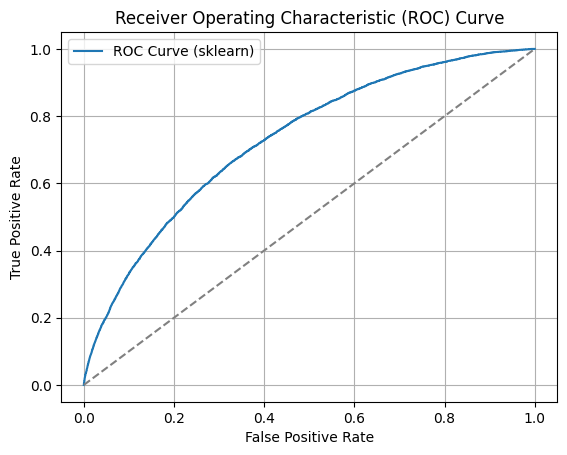

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     41698
         1.0       0.57      0.03      0.06      6206

    accuracy                           0.87     47904
   macro avg       0.72      0.51      0.49     47904
weighted avg       0.83      0.87      0.82     47904

Model run: e77706ea94f840598148031f18b64222
run.info : <RunInfo: artifact_uri='mlflow-artifacts:/127285067532811628/e77706ea94f840598148031f18b64222/artifacts', end_time=None, experiment_id='127285067532811628', lifecycle_stage='active', run_id='e77706ea94f840598148031f18b64222', run_name='Premier run expérimental', run_uuid='e77706ea94f840598148031f18b64222', start_time=1714727820859, status='RUNNING', user_id='Ariane'>


e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


<Figure size 640x480 with 0 Axes>

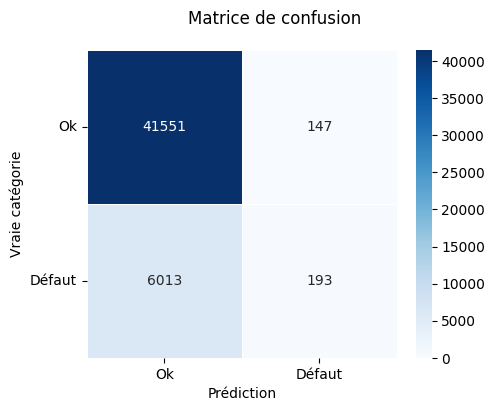

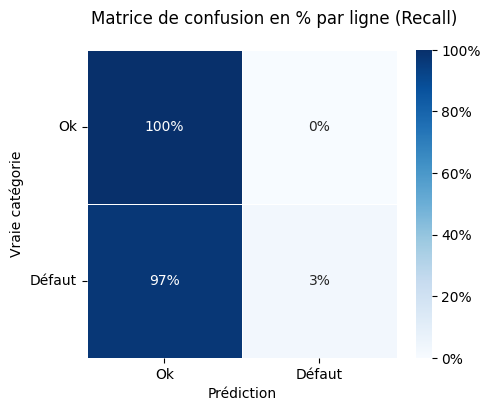

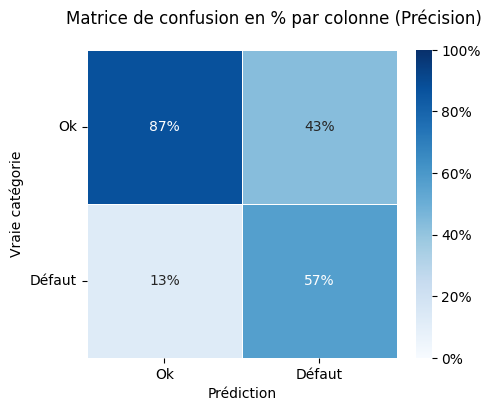

In [119]:
# Traçage de l'expérience
mlflow.set_experiment("Régression Logistique")
with mlflow.start_run(run_name="Premier run expérimental") as run:
    # Entraînement
    train_mlflow(sk_model, X_train_imputed, y_train)
    # Validation
    dic_metrics = evaluate_mlflow(sk_model, X_val_imputed, y_val)
    
    # Log  metrics that were calculated during validation
    mlflow.log_metrics(dic_metrics)
    # Log the parameters used for the model fit
    mlflow.log_params(sk_model.get_params())
    # Log an instance of the trained model for later use
    #mlflow.sklearn.log_model(sk_model=rf, input_example=X_val, artifact_path=artifact_path)
    mlflow.sklearn.log_model(sk_model, "Test 0 de mlflow sur une reg log")
    print("Model run:", mlflow.active_run().info.run_uuid)
    print("run.info :", run.info)
# Force mlflow à terminer le run même s'il y a une erreur dedans
mlflow.end_run()



Voir le résultat dans un navigateur
Dans firefox, http://127.0.0.1:8080

# Sauvegarde du modèle

In [42]:
joblib.dump(sk_model, os.path.join(MODEL_DIR, "clf_reglog_test0.pkl"))

['models/clf_reglog_test0.pkl']

# Recherche d'un Run

In [ ]:
# Le client c'est pour interroger mlflow
# For example, the following code snippet search for runs that has the best validation loss among all runs in the experiment.
client = mlflow.tracking.MlflowClient()
experiment_id = "0"
best_run = client.search_runs(
    experiment_id, order_by=["metrics.val_loss ASC"], max_results=1
)[0]
print(best_run.info)
# {'run_id': '...', 'metrics': {'val_loss': 0.123}, ...}


# Test du modèle

Charger un modèle loggé

In [53]:
loaded_model = mlflow.sklearn.load_model(
    #"runs://a1c3ff54285f47fa88f5d823d08dc943/'Test 0 de mlflow sur une reg log'"
    #"mlruns/935863330358510444/a1c3ff54285f47fa88f5d823d08dc943/artifacts"
    "runs://a1c3ff54285f47fa88f5d823d08dc943/artifacts"
)

MlflowException: Not a proper runs:/ URI: runs://a1c3ff54285f47fa88f5d823d08dc943/. Runs URIs must be of the form 'runs:/<run_id>/run-relative/path/to/artifact'

Tester le modèle

In [ ]:
loaded_model.score(X_test, y_test)

# MLFlow

Démarrer le serveur mlflow

In [ ]:
"""
Démarrer un serveur mlflow en local :
mlflow server --host 127.0.0.1 --port 8080
"""

'\nDémarrer un serveur mlflow en local :\nmlflow server --host 127.0.0.1 --port 8080\n'

Initialiser un client mlflow

In [ ]:
# NOTE: review the links mentioned above for guidance on connecting to a managed tracking server, such as the free Databricks Community Edition

client = MlflowClient(tracking_uri=URI_LOCAL)

Création d'une nouvelle expérience mlflow

In [ ]:
"""experiment_description = (
    "OC P7 Implémentez un modèle de Scoring"
    "Modèle LightGBM - Mode Debug"
)

experiment_tags = {
    "project_name": "p7",
    "store_dept": "produce",
    "team": "oc",
    "project_quarter": "Q1-2024",
    "mlflow.note.content": experiment_description,
}

lightgbm_debug_experiment = client.create_experiment(name="lightgbm_debug", tags=experiment_tags)"""

'experiment_description = (\n    "OC P7 Implémentez un modèle de Scoring"\n    "Modèle LightGBM - Mode Debug"\n)\n\nexperiment_tags = {\n    "project_name": "p7",\n    "store_dept": "produce",\n    "team": "oc",\n    "project_quarter": "Q1-2024",\n    "mlflow.note.content": experiment_description,\n}\n\nlightgbm_debug_experiment = client.create_experiment(name="lightgbm_debug", tags=experiment_tags)'

Rechercher l'expérience avec le nom du projet

In [ ]:
# Use search_experiments() to search on the project_name tag key

lightgbm_debug_experiment = client.search_experiments(
    filter_string="tags.'project_name' = 'p7'"
)

pprint(lightgbm_debug_experiment[0])

<Experiment: artifact_location='mlflow-artifacts:/768052023167465751', creation_time=1713797424132, experiment_id='768052023167465751', last_update_time=1713797424132, lifecycle_stage='active', name='lightgbm_debug', tags={'mlflow.note.content': 'OC P7 Implémentez un modèle de ScoringModèle LightGBM '
                        '- Mode Debug',
 'project_name': 'p7',
 'project_quarter': 'Q1-2024',
 'store_dept': 'produce',
 'team': 'oc'}>


In [ ]:
# Access individual tag data

print(lightgbm_debug_experiment[0].tags["team"])

oc


## Démarrer un run mlflow

In [ ]:
import mlflow

# Use the fluent API to set the tracking uri and the active experiment
mlflow.set_tracking_uri(URI_LOCAL)

# Sets the current active experiment to the "Apple_Models" experiment and returns the Experiment metadata
lightgbm_debug_experiment = mlflow.set_experiment("lightgbm_debug")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "lightgbm_debug_test"

# Define an artifact path that the model will be saved to.
artifact_path = "lightgbm_debug"

In [14]:
# Split the data into features and target and drop irrelevant date field and target field
X = data.drop(columns=["date", "demand"])
y = data["demand"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

"""params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state": 888,
}"""

LIGHTGBM_PARAMS = {
    "boosting_type": "goss",
    "n_estimators": 10000,
    "learning_rate": 0.005134,
    "num_leaves": 54,
    "max_depth": 10,
    "subsample_for_bin": 240000,
    "reg_alpha": 0.436193,
    "reg_lambda": 0.479169,
    "colsample_bytree": 0.508716,
    "min_split_gain": 0.024766,
    "subsample": 1,
    "is_unbalance": False,
    "silent": -1,
    "verbose": -1,
}

# Train the RandomForestRegressor
rf = RandomForestRegressor(**params)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf.predict(X_val)

# Calculate error metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Assemble the metrics we're going to write into a collection
metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    mlflow.log_params(LIGHTGBM_PARAMS)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(sk_model=rf, input_example=X_val, artifact_path=artifact_path)

2024/04/20 10:03:40 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\mlflow\types\utils.py:394: UserWarning:

#### Success!

You've just logged your first MLflow model! 

Navigate to the MLflow UI to see the run that was just created (named "apples_rf_test", logged to the Experiment "Apple_Models"). 